In [2]:
import dowhy
from dowhy import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Synthetic Data

In [14]:
import pandas as pd
import numpy as np
from dowhy import CausalModel

np.random.seed(42)
df_test = pd.DataFrame({
    'treatment': np.random.binomial(1, 0.5, 1000),
    'age': np.random.normal(30, 10, 1000),
})
df_test['outcome'] = 5 * df_test['treatment'] + 0.3 * df_test['age'] + np.random.normal(0, 1, 1000)

model_test = CausalModel(
    data=df_test,
    treatment='treatment',
    outcome='outcome',
    common_causes=['age']
)

estimand_test = model_test.identify_effect()
estimate_test = model_test.estimate_effect(estimand_test, method_name="backdoor.linear_regression")

print("Test ATE:", estimate_test.value)


Test ATE: 5.07580007917422


/workspaces/Causal_Analysis/.venv/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [3]:
# Load the dataset: Lalonde
lalonde = datasets.lalonde_dataset()
lalonde_df = pd.DataFrame(lalonde)

In [4]:
lalonde_df.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75
0,False,23.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,1.0
1,False,26.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,12383.68,1.0,1.0
2,False,22.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,1.0
3,False,18.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,10740.08,1.0,1.0
4,False,45.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,11796.47,1.0,1.0


# EDA

In [5]:
# Shape and data types
lalonde_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   treat    445 non-null    bool   
 1   age      445 non-null    float64
 2   educ     445 non-null    float64
 3   black    445 non-null    float64
 4   hisp     445 non-null    float64
 5   married  445 non-null    float64
 6   nodegr   445 non-null    float64
 7   re74     445 non-null    float64
 8   re75     445 non-null    float64
 9   re78     445 non-null    float64
 10  u74      445 non-null    float64
 11  u75      445 non-null    float64
dtypes: bool(1), float64(11)
memory usage: 38.8 KB


In [6]:
# summary statistics
lalonde_df.describe()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75
count,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,25.370787,10.195506,0.833708,0.08764,0.168539,0.782022,2102.265311,1377.138368,5300.763699,0.732584,0.649438
std,7.100282,1.792119,0.372762,0.28309,0.374766,0.413337,5363.582400,3150.960771,6631.491695,0.443109,0.477683
min,17.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,9.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,10.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,3701.812000,1.000000,1.000000
75%,28.000000,11.000000,1.000000,0.00000,0.000000,1.000000,824.388900,1220.836000,8124.715000,1.000000,1.000000
max,55.000000,16.000000,1.000000,1.00000,1.000000,1.000000,39570.680000,25142.240000,60307.930000,1.000000,1.000000


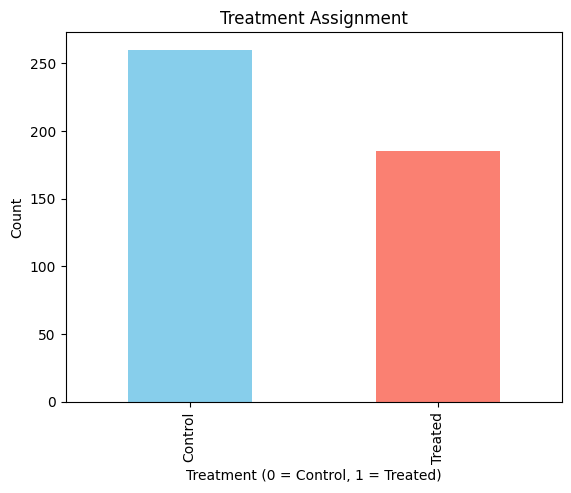

In [7]:
# Count of treated vs control
lalonde_df['treat'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Treatment Assignment")
plt.xlabel("Treatment (0 = Control, 1 = Treated)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Control", "Treated"])
plt.show()


/tmp/ipykernel_1763/3048988960.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='treat', y='re78', data=lalonde_df, palette='Set2')


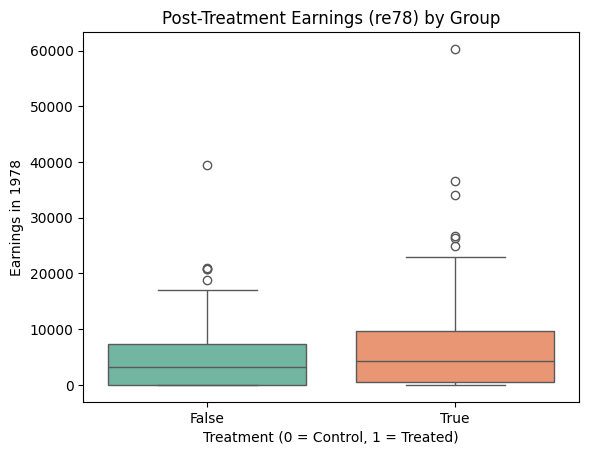

In [8]:
# Compare earnings by treatment group
sns.boxplot(x='treat', y='re78', data=lalonde_df, palette='Set2')
plt.title("Post-Treatment Earnings (re78) by Group")
plt.xlabel("Treatment (0 = Control, 1 = Treated)")
plt.ylabel("Earnings in 1978")
plt.show()


In [9]:
# Any missing data?
lalonde_df.isnull().sum()


treat      0
age        0
educ       0
black      0
hisp       0
married    0
nodegr     0
re74       0
re75       0
re78       0
u74        0
u75        0
dtype: int64

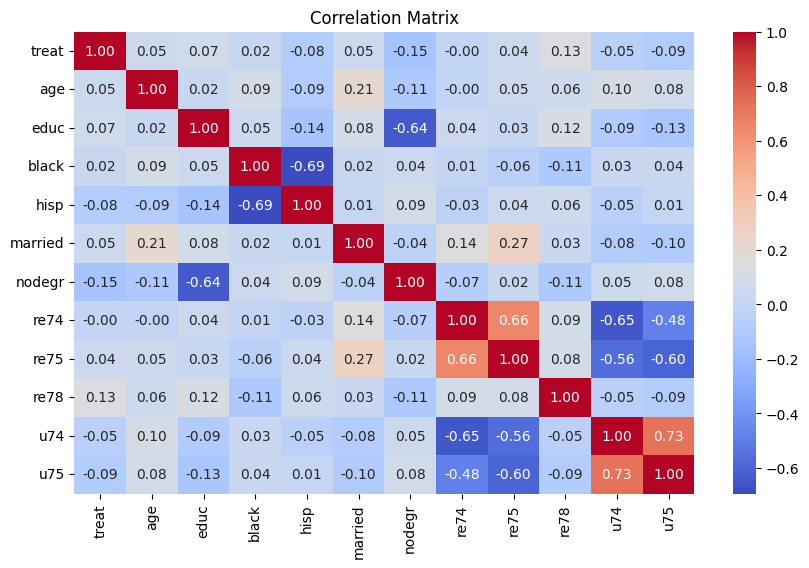

In [10]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(lalonde_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [11]:
lalonde_df.columns

Index(['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74',
       're75', 're78', 'u74', 'u75'],
      dtype='object')

# Goal of the Analysis

Estimate the causal effect of participating in a job training program (treatment, or the column 'treat') on the earnings in 1978 (the column re78)

`treat` is treatment variable

`re78` outcome variable

`age`, `educ`, `black`, `hisp`, `married`, `nodegr`, `re74`,`re75` confounders, which can affect both treatment and outcome 


/workspaces/Causal_Analysis/.venv/lib/python3.12/site-packages/dowhy/causal_model.py:583: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


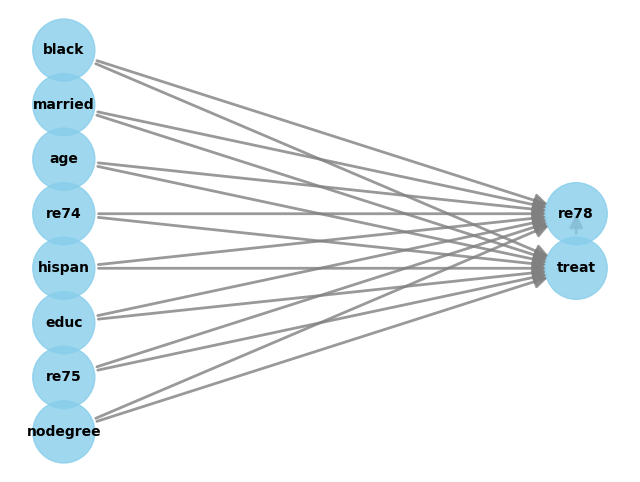

In [12]:
from dowhy import CausalModel

model = CausalModel(
    data=lalonde_df,
    treatment='treat',
    outcome='re78',
    common_causes=['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
)
model.view_model()


/workspaces/Causal_Analysis/.venv/lib/python3.12/site-packages/dowhy/causal_model.py:583: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


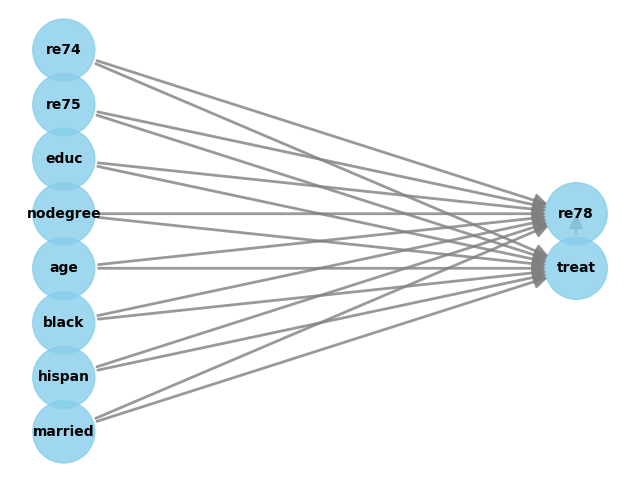

In [5]:
from dowhy import CausalModel
import dowhy.plotter

model = CausalModel(
    data=lalonde_df,
    treatment='treat',
    outcome='re78',
    common_causes=['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
)

model.view_model()


# Estimate the Causal Effect using Matching

Average Treatment Effect (ATE) using matching

In [6]:
# Identify the causal effect using matching
identified_estimand = model.identify_effect()

# Estimate the effect using Propensity Score Matching
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

print("Estimated ATE:", estimate.value)


Estimated ATE: None


In [8]:
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [9]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="ate",  # average treatment effect
    method_params={
        "verbose": True
    }
)


In [10]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print("Estimated ATE (regression):", estimate.value)


Estimated ATE (regression): None


In [7]:
# Simple placebo test: replace outcome with a random variable
refute = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)

print(refute)


ValueError: Aborting refutation! No valid estimate is provided.

In [11]:
lalonde_df['treat'].value_counts()


treat
False    260
True     185
Name: count, dtype: int64

In [12]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print("Estimated ATE (Linear Regression):", estimate.value)


Estimated ATE (Linear Regression): None


In [13]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting"
)

print("Estimated ATE (IPW):", estimate.value)


Estimated ATE (IPW): None


No matching found. New example needed?
